# show how this work

The idea here is to have four panels beside each other representing the steps it takes to take an individual object, and a model, and spit out a probability for it

far left: information on an object - mass, parallax, solution type

1: a slice of a sc cube for the solution type in question in $(T,\lambda)$

1.5: right arrow, above it saying 'adjust for mass, parallax of the object'

2: adjusted sc cube slice in $(T,q)$

3: model cube in $(T,q)$

4: multiplication of the two cubes

far right: arrow and then an overall probability written as a %

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sc_cubes = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))
t_loaded = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')

In [49]:
target_object = {
    'mass': 0.3,
    'parallax': 7,
    'solution_type': 12,
    'soltype_index': 1
}

In [50]:
#1 extract sc slice
sc_cube = sc_cubes["data"][sc_cubes["meta"]["parallaxes"][1]][:,:,target_object["soltype_index"]]/250

#2 convert it to q space
grid_size = (35,20)
using_periods = np.linspace(1,8,grid_size[0]+2)
using_qs = np.linspace(0.05,0.5,grid_size[1]+2)
adjusted_sc_cube = Sampler.compute_grid(target_object, sc_cubes, using_periods[1:-2], using_qs[1:-2], q_space=True)

#3 choose model
model_cube = Sampler.create_model_cube(grid_size, p_model=(4,1.3))

#4 multiply together
convolved_cube = adjusted_sc_cube*model_cube

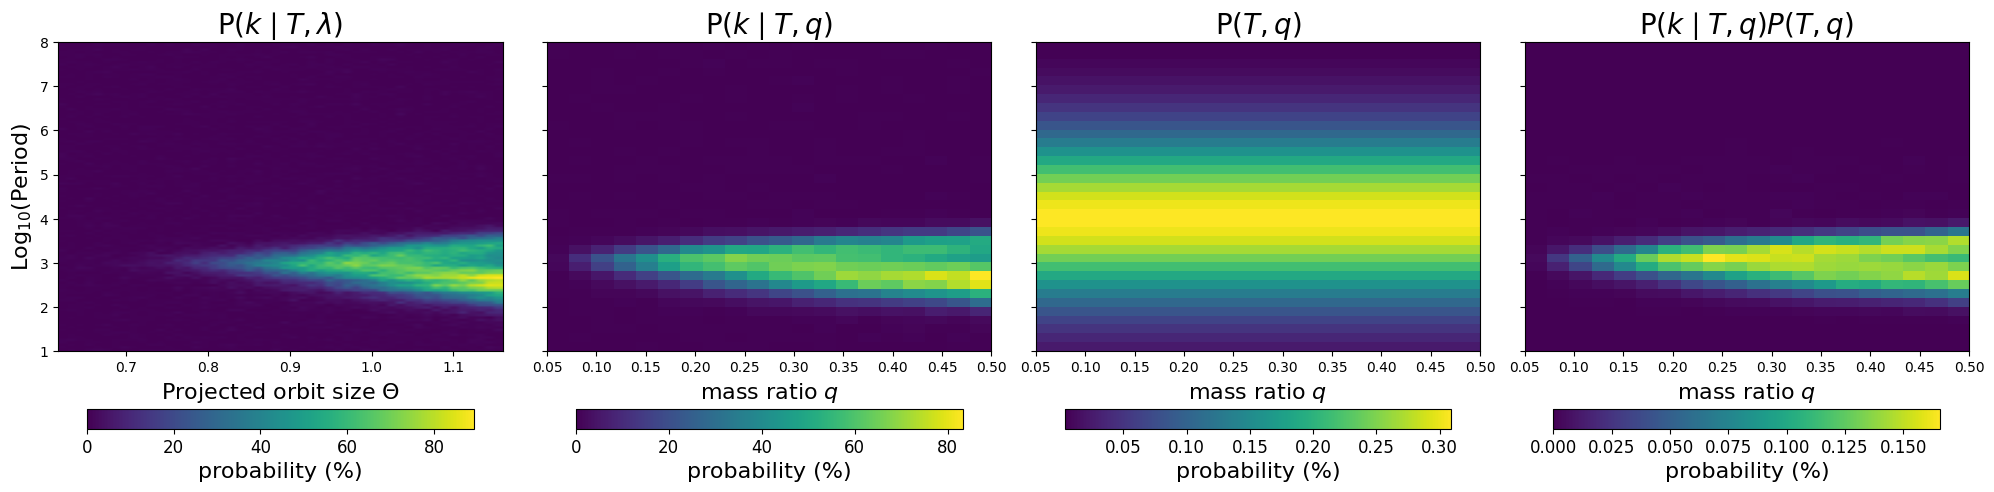

In [105]:
def plot_imshow(ax, grid, ys, xs):
    im = ax.imshow(grid, extent=[xs[0], xs[-1], ys[-1], ys[0]], aspect="auto")
    ax.invert_yaxis()
    return im

labelsize = 16
titlesize = 20

fig, axs = plt.subplots(1, 4, figsize=(20,5), sharey=True)

axs[0].set_ylabel(r'Log$_{10}$(Period)', fontsize=labelsize)
axs[0].set_xlabel(r'Projected orbit size $\Theta$', fontsize=labelsize)
axs[1].set_xlabel(r'mass ratio $q$', fontsize=labelsize)
axs[2].set_xlabel(r'mass ratio $q$', fontsize=labelsize)
axs[3].set_xlabel(r'mass ratio $q$', fontsize=labelsize)

axs[0].set_title(r'P$(k\mid T,\lambda)$', fontsize=titlesize)
axs[1].set_title(r'P$(k\mid T,q)$', fontsize=titlesize)
axs[2].set_title(r'P$(T,q)$', fontsize=titlesize)
axs[3].set_title(r'P$(k\mid T,q)P(T,q)$', fontsize=titlesize)

im0 = plot_imshow(axs[0], 100*sc_cube, np.log10(sc_cubes["meta"]["periods"]), np.array(sc_cubes["meta"]["lambdas"][1])**(1/4))
im1 = plot_imshow(axs[1], 100*adjusted_sc_cube, using_periods, using_qs)
im2 = plot_imshow(axs[2], 100*model_cube, using_periods, using_qs)
im3 = plot_imshow(axs[3], 100*convolved_cube, using_periods, using_qs)

for ax, im in zip(axs, [im0, im1, im2, im3]):
    cbar = fig.colorbar(
        im,
        ax=ax,
        orientation="horizontal",
        pad=0.15,      # distance from plot
        fraction=0.05,  # thickness
    )
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label("probability (%)", size=16)

plt.tight_layout()
plt.savefig("./plots/demonstration.jpg");

In [106]:
convolved_cube.sum()

np.float64(0.1237442218764395)